# From Pyro to NumPyro: Forecasting Hierarchical Models - Part III (Deep State-Space Model)

In this third notebook, we extend the hierarchical forecasting models from [Part II](https://juanitorduz.github.io/numpyro_hierarchical_forecasting_2/) by adding a neural network component to the state transition function. This approach is inspired by Deep State-Space Models (DSSM), which combine the interpretability of state-space models with the flexibility of neural networks.

**Key changes from Part II:**
- Add a neural network that learns **shared temporal patterns** from (previous_level, time)
- Station-specific parameters (`station_drift_bias`, `station_drift_scale`) modulate the NN output
- Use cyclical time encoding (sin/cos of hour of week) for temporal features
- All other components (seasonal, pairwise, scales) remain identical to Part II

We use [Flax NNX](https://flax.readthedocs.io/) for the neural network module, integrated with NumPyro via `nnx_module` following the pattern from the [Causal Effect Estimation notebook](https://juanitorduz.github.io/online_game_ate/).


## Prepare Notebook


In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from flax import nnx
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.contrib.module import nnx_module
from numpyro.examples.datasets import load_bart_od
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=14)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
# %load_ext jaxtyping
# %jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Read Data


In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
(78888, 50, 50)
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


In this example, we model all the rides from all stations to all other stations.


In [3]:
data = jnp.log1p(np.permute_dims(dataset["counts"], (1, 2, 0)))
T = data.shape[-2]
print(data.shape)

(50, 50, 78888)


## Train - Test Split

Similarly as in the previous examples, for training purposes we will use data from 90 days before the test data.


In [4]:
T2 = data.shape[-1]  # end
T1 = T2 - 24 * 7 * 2  # train/test split
T0 = T1 - 24 * 90  # beginning: train on 90 days of data

In [5]:
y = data[..., T0:T2]
y_train = data[..., T0:T1]
y_test = data[..., T1:T2]

print(f"y: {y.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

y: (50, 50, 2496)
y_train: (50, 50, 2160)
y_test: (50, 50, 336)


In [6]:
n_stations = y_train.shape[0]

time = jnp.array(range(T0, T2))
time_train = jnp.array(range(T0, T1))
t_max_train = time_train.size

time_test = jnp.array(range(T1, T2))
t_max_test = time_test.size

covariates = jnp.zeros_like(y)
covariates_train = jnp.zeros_like(y_train)
covariates_test = jnp.zeros_like(y_test)

assert time_train.size + time_test.size == time.size
assert y_train.shape == (n_stations, n_stations, t_max_train)
assert y_test.shape == (n_stations, n_stations, t_max_test)
assert covariates.shape == y.shape
assert covariates_train.shape == y_train.shape
assert covariates_test.shape == y_test.shape

## Repeating Seasonal Features

We also need the JAX version of the [`periodic_repeat`](https://docs.pyro.ai/en/stable/ops.html#pyro.ops.tensor_utils.periodic_repeat) function.


In [7]:
def periodic_repeat_jax(tensor: Array, size: int, dim: int) -> Array:
    """
    Repeat a period-sized tensor up to given size using JAX.

    Parameters
    ----------
    tensor : Array
        A JAX array to be repeated.
    size : int
        Desired size of the result along dimension `dim`.
    dim : int
        The tensor dimension along which to repeat.

    Returns
    -------
    Array
        The repeated tensor.

    References
    ----------
    https://docs.pyro.ai/en/stable/ops.html#pyro.ops.tensor_utils.periodic_repeat
    """
    assert isinstance(size, int) and size >= 0
    assert isinstance(dim, int)
    if dim >= 0:
        dim -= tensor.ndim

    period = tensor.shape[dim]
    repeats = [1] * tensor.ndim
    repeats[dim] = (size + period - 1) // period
    result = jnp.tile(tensor, repeats)

    slices = [slice(None)] * tensor.ndim
    slices[dim] = slice(None, size)

    return result[tuple(slices)]

## Neural Network Definition

We define a single Flax NNX module for our Deep State-Space Model:

**TransitionMLP**: A neural network that learns shared temporal patterns from `(previous_level, sin_time, cos_time)`. The output is then modulated by station-specific probabilistic parameters defined in the model.


In [ ]:
class StationEmbedding(nnx.Module):
    """Learnable embeddings for stations.

    This is CRITICAL for the NN to learn station-specific dynamics.
    Without it, the NN produces identical outputs for all stations.
    """

    def __init__(self, n_stations: int, embed_dim: int, rngs: nnx.Rngs):
        self.embedding = nnx.Embed(
            num_embeddings=n_stations,
            features=embed_dim,
            rngs=rngs,
        )

    def __call__(self, station_idx: jax.Array) -> jax.Array:
        return self.embedding(station_idx)


class TransitionNetwork(nnx.Module):
    """Enhanced transition network with station embeddings.

    Architecture:
    - Station embedding: maps station index to dense vector
    - Input: [normalized_level, sin_hour, cos_hour, sin_dow, cos_dow, station_embed]
    - Simple MLP with tanh activations (numerically stable)
    - Output: tanh-bounded delta

    Note: We use tanh instead of ReLU+LayerNorm for better numerical stability.
    """

    def __init__(
        self,
        n_stations: int,
        embed_dim: int,
        hidden_dims: list[int],
        rngs: nnx.Rngs,
    ) -> None:
        self.embed_dim = embed_dim

        # Station embedding
        self.station_embed = StationEmbedding(n_stations, embed_dim, rngs)

        # Input: normalized_level(1) + hour_sin_cos(2) + dow_sin_cos(2) + embed(embed_dim) # noqa: E501
        input_dim = 1 + 2 + 2 + embed_dim

        # Build simple MLP (no LayerNorm for stability)
        self.layers = nnx.List([])

        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nnx.Linear(prev_dim, hidden_dim, rngs=rngs))
            prev_dim = hidden_dim

        # Output layer
        self.output_layer = nnx.Linear(prev_dim, 1, rngs=rngs)

    def __call__(
        self,
        normalized_level: jax.Array,  # (n_stations,)
        hour_of_day: float,  # 0-23
        day_of_week: float,  # 0-6
        station_indices: jax.Array,  # (n_stations,)
    ) -> jax.Array:
        n_stations = normalized_level.shape[0]

        # Get station embeddings: (n_stations, embed_dim)
        station_emb = self.station_embed(station_indices)

        # Cyclical encoding of hour of day: (n_stations, 2)
        hour_angle = 2 * jnp.pi * hour_of_day / 24.0
        hour_features = jnp.broadcast_to(
            jnp.stack([jnp.sin(hour_angle), jnp.cos(hour_angle)]),
            (n_stations, 2),
        )

        # Cyclical encoding of day of week: (n_stations, 2)
        dow_angle = 2 * jnp.pi * day_of_week / 7.0
        dow_features = jnp.broadcast_to(
            jnp.stack([jnp.sin(dow_angle), jnp.cos(dow_angle)]),
            (n_stations, 2),
        )

        # Concatenate all features
        x = jnp.concatenate(
            [
                normalized_level[:, None],  # (n_stations, 1)
                hour_features,  # (n_stations, 2)
                dow_features,  # (n_stations, 2)
                station_emb,  # (n_stations, embed_dim)
            ],
            axis=-1,
        )

        # Forward through MLP with tanh activations (bounded, stable)
        for layer in self.layers:
            x = jnp.tanh(layer(x))

        # Output with tanh for bounded output in [-1, 1]
        return jnp.tanh(self.output_layer(x))

## Initialize Neural Network (Outside Model)

Following the pattern from [online_game_ate](https://juanitorduz.github.io/online_game_ate/), we initialize the neural network **outside** the model function and pass it as an argument. This is required for NumPyro's `nnx_module` integration to work correctly.


In [9]:
# =====================================================================
# Neural Network Configuration - Enhanced Architecture
# =====================================================================
# Key improvements over baseline:
# 1. Station embeddings: NN knows which station it's processing
# 2. Richer time features: separate hour-of-day and day-of-week
# 3. LayerNorm: stability without constraining capacity
# 4. Larger hidden layers: more expressive power
#
# Input dimensions:
#   - normalized_level: 1
#   - hour_of_day sin/cos: 2
#   - day_of_week sin/cos: 2
#   - station_embedding: embed_dim
#   Total: 5 + embed_dim
# =====================================================================

# Hyperparameters
embed_dim = 16  # station embedding dimension
hidden_dims = [4, 8, 4]  # hidden layer sizes

# Initialize random number generators for Flax
rng_key, rng_subkey = random.split(rng_key)

# Initialize the enhanced transition network
transition_nn = TransitionNetwork(
    n_stations=n_stations,
    embed_dim=embed_dim,
    hidden_dims=hidden_dims,
    rngs=nnx.Rngs(rng_subkey),
)

print("Enhanced Transition Network:")
print(f"  Station embedding: {n_stations} stations -> {embed_dim} dims")
print(f"  Input dim: {5 + embed_dim} (level + hour + dow + embed)")
print(f"  Hidden dims: {hidden_dims}")
print("  Output: 1 (tanh-bounded delta)")

Enhanced Transition Network:
  Station embedding: 50 stations -> 16 dims
  Input dim: 21 (level + hour + dow + embed)
  Hidden dims: [4, 8, 4]
  Output: 1 (tanh-bounded delta)


## Model Specification

The Deep State-Space Model extends Part II by adding an **enhanced neural network** to the transition function.

**Key architectural improvements:**
1. **Station embeddings**: NN knows which station it's processing (critical for station-specific dynamics!)
2. **Richer temporal features**: Separate hour-of-day and day-of-week encodings
3. **Tanh activations throughout**: All intermediate values bounded to [-1, 1] for numerical stability

**Numerical stability:**
- Normalize `previous_level` with `tanh(level / 10)` to keep inputs bounded
- `drift_scale ~ LogNormal(-7, 0.5)` gives ~0.001 per-step deltas
- All NN activations use tanh (bounded outputs)
- Safety clipping at ±50 prevents overflow

**Model components:**
- Neural network learns **station-specific** temporal patterns via embeddings
- Seasonal, pairwise, and scale parameters remain identical to Part II


In [10]:
def model(
    covariates: Float[Array, "n_series n_series t_max"],
    transition_nn: TransitionNetwork,
    y: Float[Array, "n_series n_series t_max"] | None = None,
) -> None:
    """
    Enhanced Deep State-Space Model with station-aware neural network transition.

    Key improvements over baseline:
    1. Station embeddings: NN learns station-specific dynamics
    2. Richer temporal features: separate hour and day-of-week encodings
    3. LayerNorm: stability without constraining capacity
    4. Larger hidden layers: more expressive power
    """
    # Get the time and feature dimensions
    n_series, _, t_max = covariates.shape

    # Register neural network with NumPyro for optimization
    transition_nn = nnx_module("transition", transition_nn)

    # Define the plates
    origin_plate = numpyro.plate("origin", n_series, dim=-3)
    destin_plate = numpyro.plate("destin", n_series, dim=-2)
    hour_of_week_plate = numpyro.plate("hour_of_week", 24 * 7, dim=-1)

    # =====================================================================
    # DRIFT PARAMETERS - Tight priors for numerical stability
    # With station embeddings, NN can still learn station-specific patterns
    # even with small drift scale because embeddings differentiate stations
    # =====================================================================
    # Global drift scale: exp(-7) ≈ 0.001, small but NN embeddings add expressiveness
    drift_scale = numpyro.sample("drift_scale", dist.LogNormal(loc=-7, scale=0.5))

    # Seasonal components (same as Part II)
    with origin_plate, hour_of_week_plate:
        origin_seasonal = numpyro.sample("origin_seasonal", dist.Normal(loc=0, scale=5))

    with destin_plate, hour_of_week_plate:
        destin_seasonal = numpyro.sample("destin_seasonal", dist.Normal(loc=0, scale=5))

    # Pairwise station affinity (same as Part II)
    with origin_plate, destin_plate:
        pairwise = numpyro.sample("pairwise", dist.Normal(0, 1))

    # Observation scales (same as Part II)
    with origin_plate:
        origin_scale = numpyro.sample("origin_scale", dist.LogNormal(-5, 5))
    with destin_plate:
        destin_scale = numpyro.sample("destin_scale", dist.LogNormal(-5, 5))
        scale = origin_scale + destin_scale

    # Repeat the seasonal parameters to match the length of the time series
    seasonal = origin_seasonal + destin_seasonal
    seasonal_repeat = periodic_repeat_jax(seasonal, t_max, dim=-1)

    # Station indices for embeddings (0, 1, 2, ..., n_series-1)
    station_indices = jnp.arange(n_series)

    # Neural transition function
    def transition_fn(
        carry: Float[Array, " n_series"], t: int
    ) -> tuple[Float[Array, " n_series"], Float[Array, " n_series"]]:
        """Enhanced neural network transition with station embeddings.

        The NN now receives:
        - Normalized previous level
        - Hour of day (cyclical encoding)
        - Day of week (cyclical encoding)
        - Station embedding (learned)

        This allows station-specific dynamics!
        """
        previous_level = carry  # (n_series,)

        # Normalize previous_level to keep NN inputs bounded
        normalized_level = jnp.tanh(previous_level / 10.0)

        # Compute hour of day and day of week from time index
        hour_of_week = t % (24 * 7)
        hour_of_day = hour_of_week % 24  # 0-23
        day_of_week = hour_of_week // 24  # 0-6

        # Call enhanced transition network with station embeddings
        raw_nn_output = transition_nn(
            normalized_level=normalized_level,
            hour_of_day=hour_of_day,
            day_of_week=day_of_week,
            station_indices=station_indices,
        ).reshape(n_series)  # (n_series,)

        # Delta = nn_output * drift_scale
        # NN output is in [-1, 1] from tanh, drift_scale ~ 0.007
        delta = raw_nn_output * drift_scale

        # Update level with clipping for safety
        current_level = previous_level + delta
        current_level = jnp.clip(current_level, -50.0, 50.0)

        return current_level, current_level

    # Compute the latent levels using scan
    _, pred_levels = scan(
        transition_fn, init=jnp.zeros((n_series,)), xs=jnp.arange(t_max)
    )

    # Transpose prediction levels: (t_max, n_series) -> (n_series, t_max)
    pred_levels = pred_levels.transpose(1, 0)

    # Add origin dimension for broadcasting: (n_series, t_max) -> (1, n_series, t_max)
    pred_levels = pred_levels[None, :, :]

    # Compute the mean of the model
    mu = pred_levels + seasonal_repeat + pairwise

    # Sample the observations
    with numpyro.handlers.condition(data={"obs": y}):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=scale))

We can now visualize the model structure.


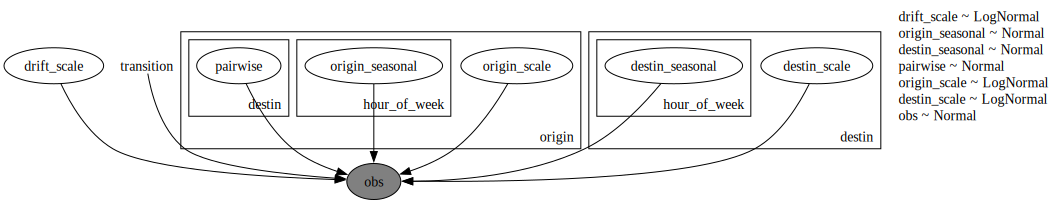

In [11]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "covariates": covariates_train,
        "transition_nn": transition_nn,
        "y": y_train,
    },
    render_distributions=True,
    render_params=True,
)

## Prior Predictive Checks

As usual (highly recommended!), we should perform prior predictive checks.


In [12]:
prior_predictive = Predictive(model=model, num_samples=500, return_sites=["obs"])

rng_key, rng_subkey = random.split(rng_key)

prior_samples = prior_predictive(
    rng_subkey,
    covariates_train,
    transition_nn,
)

idata_prior = az.from_dict(
    prior_predictive={k: v[None, ...] for k, v in prior_samples.items()},
    coords={
        "time_train": time_train,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time_train"]},
)

Let's plot the prior predictive distribution for the first $8$ stations for the destination station `ANTC`.


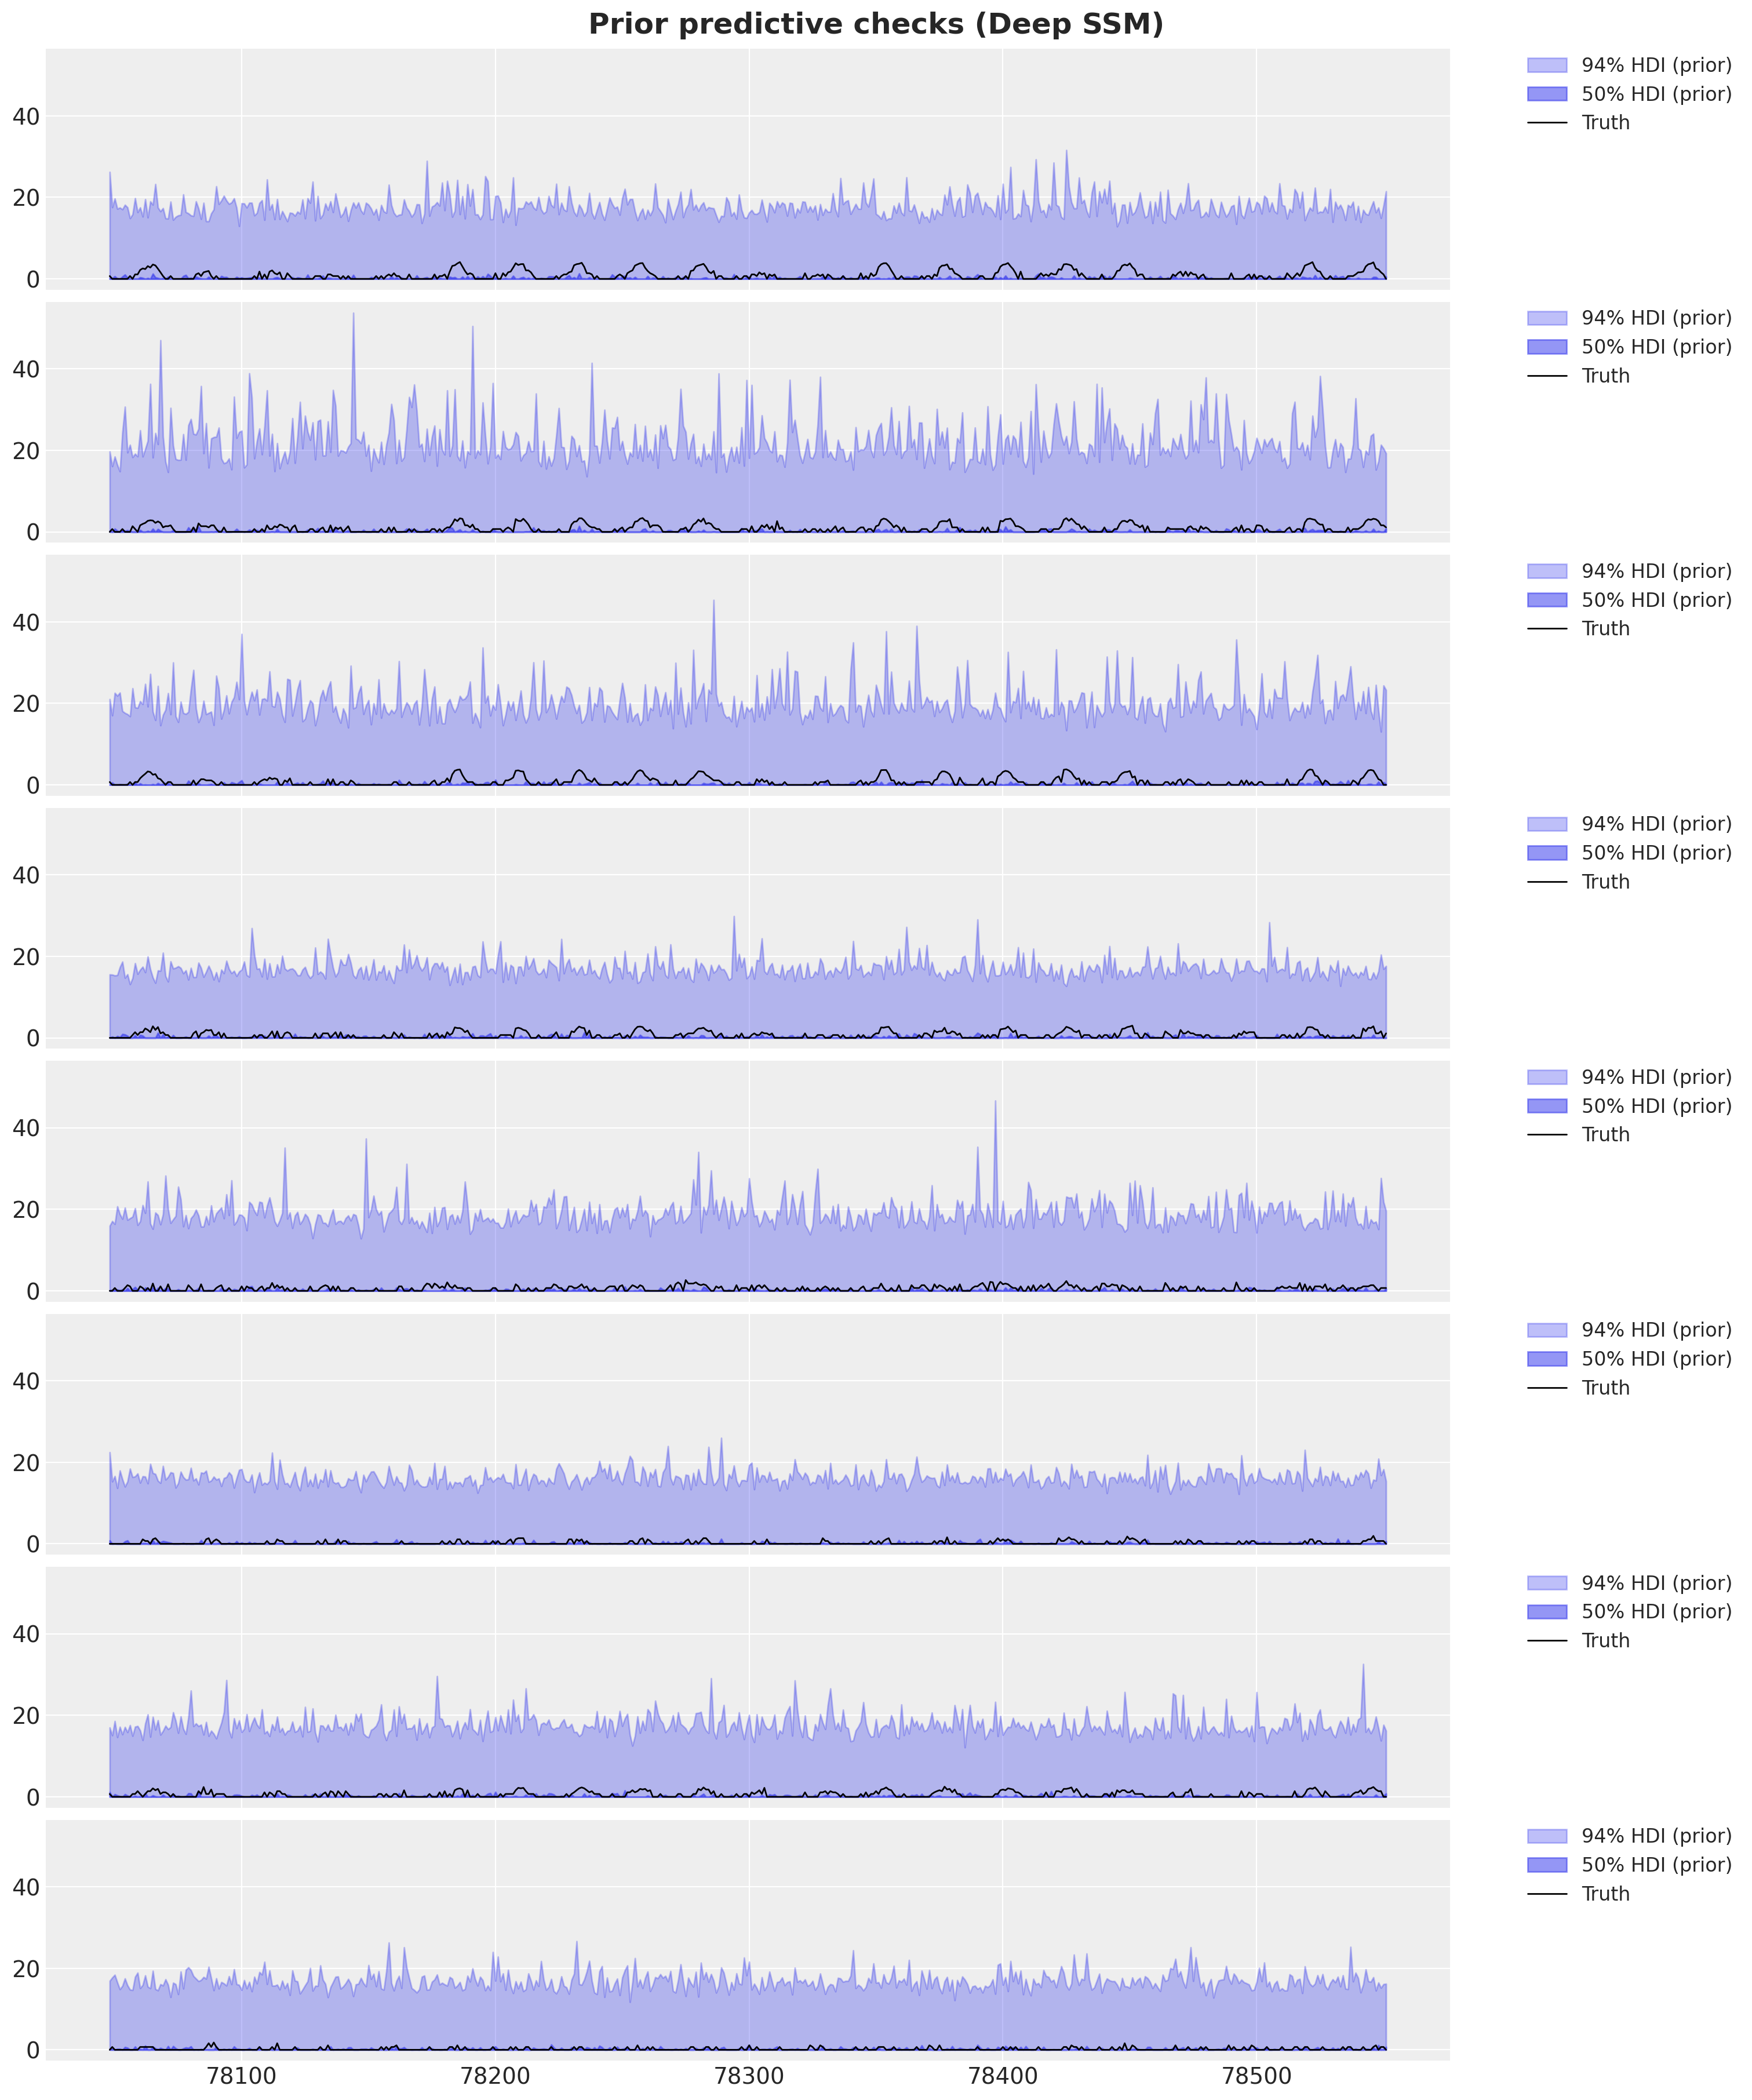

In [13]:
station = "ANTC"
idx = np.nonzero(dataset["stations"] == station)[0].item()

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(15, 18), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 3 * (24 * 7)],
            idata_prior["prior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time_train) >= T1 - 3 * (24 * 7)]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (prior)",
            },
            smooth=False,
            ax=ax,
        )

    ax.plot(
        time_train[time_train >= T1 - 3 * (24 * 7)],
        data[i, idx, T1 - 3 * (24 * 7) : T1],
        "black",
        lw=1,
        label="Truth",
    )

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
    )

fig.suptitle("Prior predictive checks (Deep SSM)", fontsize=18, fontweight="bold");

## Inference with SVI

We now fit the model to the data using stochastic variational inference. Note that we need to pass the neural networks as arguments to `svi.run()`.


100%|██████████| 35000/35000 [18:32<00:00, 31.46it/s, init loss: 3805086976.0000, avg. loss [33251-35000]: 3669108.2500]


CPU times: user 36min 47s, sys: 7min 3s, total: 43min 51s
Wall time: 18min 39s


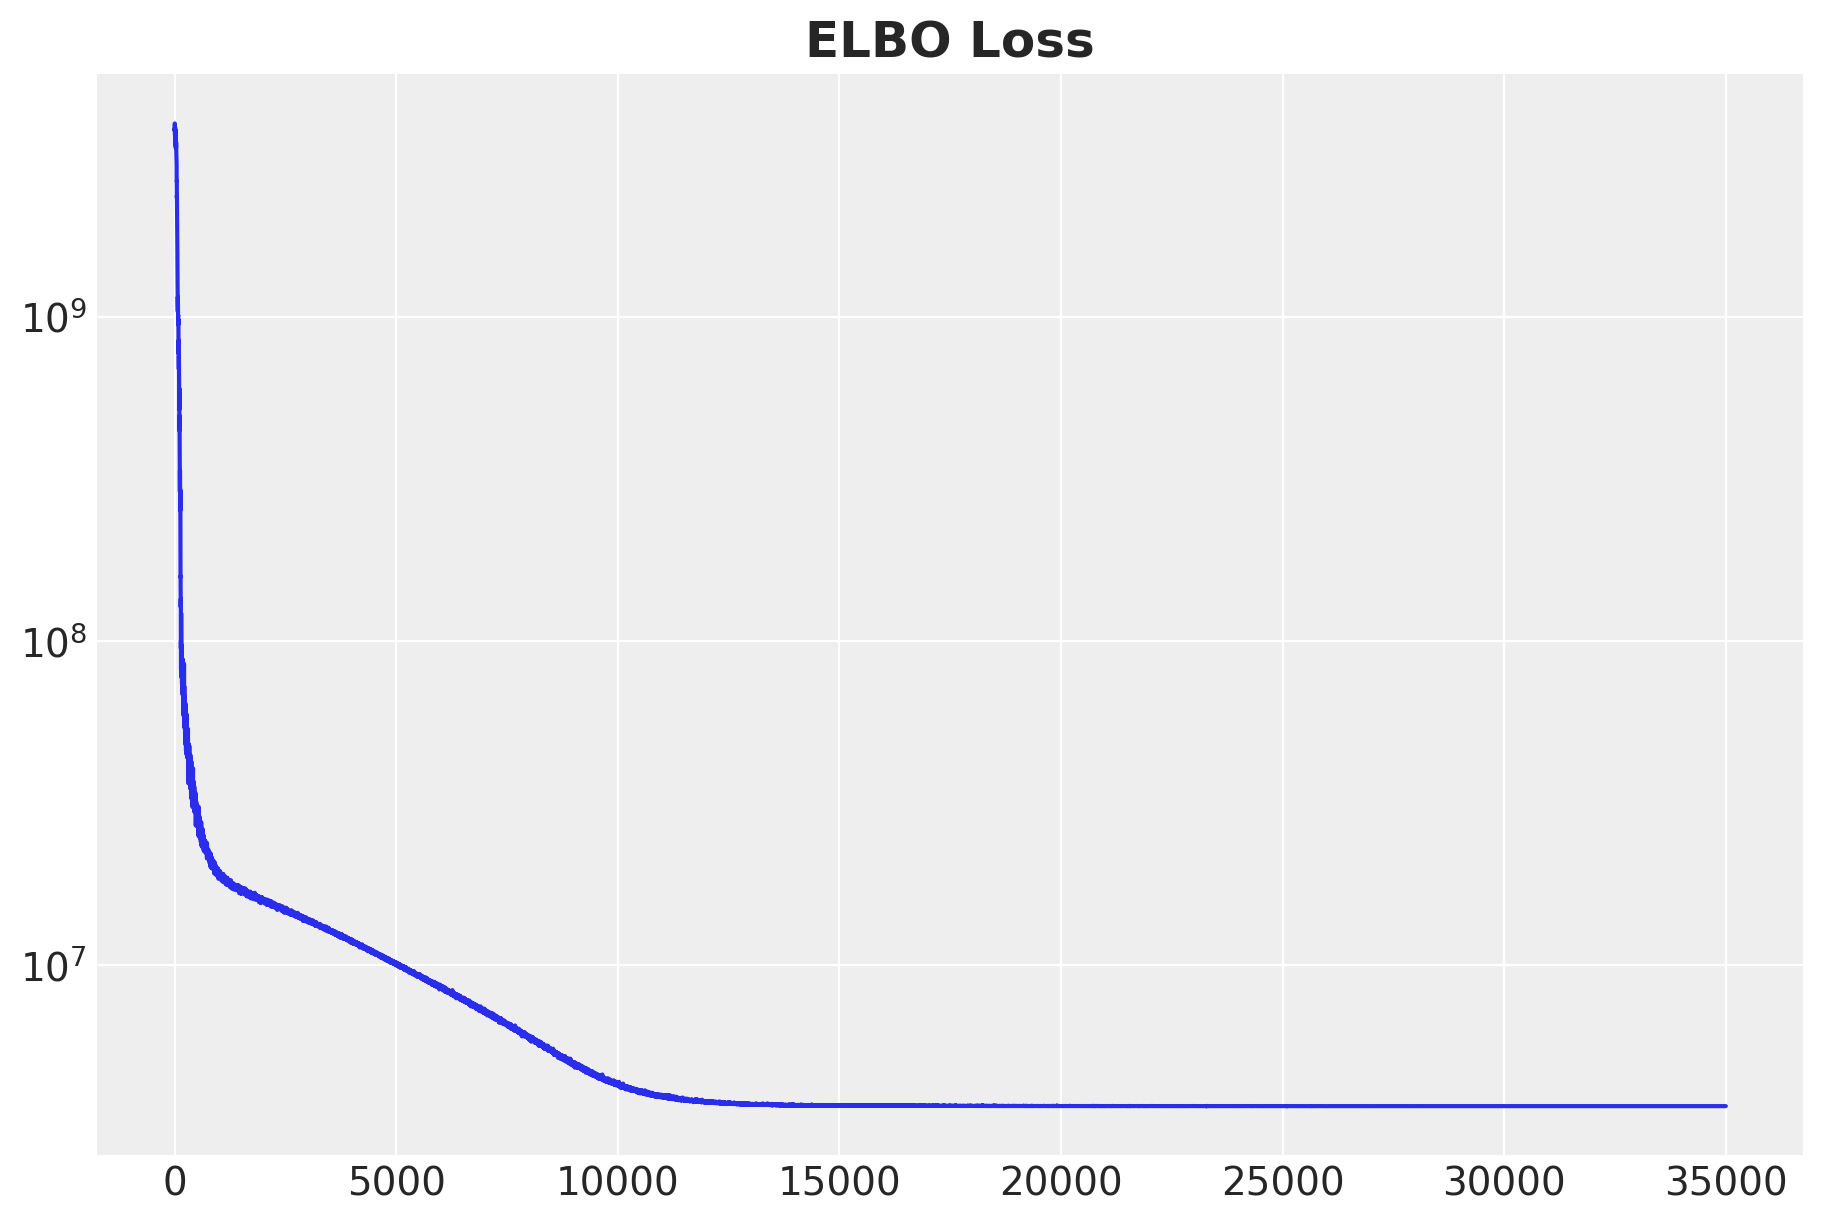

In [14]:
%%time

num_steps = 35_000

scheduler = optax.linear_onecycle_schedule(
    transition_steps=num_steps,
    peak_value=0.001,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=3,
)

optimizer = optax.chain(
    optax.adam(learning_rate=scheduler),
    optax.contrib.reduce_on_plateau(
        factor=0.8,
        patience=20,
        accumulation_size=100,
    ),
)

guide = AutoNormal(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    covariates_train,
    transition_nn,
    y_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set_title("ELBO Loss", fontsize=18, fontweight="bold");

## Posterior Predictive Check

Next, we generate posterior predictive samples for the forecast for each of the station pairs.


In [15]:
posterior = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=200,
    return_sites=["obs"],
)

In [16]:
rng_key, rng_subkey = random.split(rng_key)

idata_train = az.from_dict(
    posterior_predictive={
        k: v[None, ...]
        for k, v in posterior(
            rng_subkey,
            covariates_train,
            transition_nn,
        ).items()
    },
    coords={
        "time_train": time_train,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time_train"]},
)

idata_test = az.from_dict(
    posterior_predictive={
        k: v[None, ...]
        for k, v in posterior(
            rng_subkey,
            covariates,
            transition_nn,
        ).items()
    },
    coords={
        "time": time,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time"]},
)

To evaluate the model performance, we compute the CRPS for the training and test data. For comparison purposes, we clip the data to ensure the predictions are non-negative.


In [17]:
@jax.jit
def crps(
    truth: Float[Array, "n_series n_series t_max"],
    pred: Float[Array, "n_samples n_series n_series t_max"],
    sample_weight: Float[Array, " t_max"] | None = None,
) -> Float[Array, ""]:
    if pred.shape[1:] != (1,) * (pred.ndim - truth.ndim - 1) + truth.shape:
        raise ValueError(
            f"""Expected pred to have one extra sample dim on left.
            Actual shapes: {pred.shape} versus {truth.shape}"""
        )

    absolute_error = jnp.mean(jnp.abs(pred - truth), axis=0)

    num_samples = pred.shape[0]
    if num_samples == 1:
        return jnp.average(absolute_error, weights=sample_weight)

    pred = jnp.sort(pred, axis=0)
    diff = pred[1:] - pred[:-1]
    weight = jnp.arange(1, num_samples) * jnp.arange(num_samples - 1, 0, -1)
    weight = weight.reshape(weight.shape + (1,) * (diff.ndim - 1))

    per_obs_crps = absolute_error - jnp.sum(diff * weight, axis=0) / num_samples**2
    return jnp.average(per_obs_crps, weights=sample_weight)


crps_train = crps(
    y_train,
    jnp.array(idata_train["posterior_predictive"]["obs"].sel(chain=0).clip(min=0)),
)

crps_test = crps(
    y_test,
    jnp.array(
        idata_test["posterior_predictive"]["obs"]
        .sel(chain=0)
        .sel(time=slice(T1, T2))
        .clip(min=0)
    ),
)

print(f"Train CRPS: {crps_train:.4f}")
print(f"Test CRPS: {crps_test:.4f}")

Train CRPS: 0.2378
Test CRPS: 0.2754


Finally, we visualize the model fit and forecast.


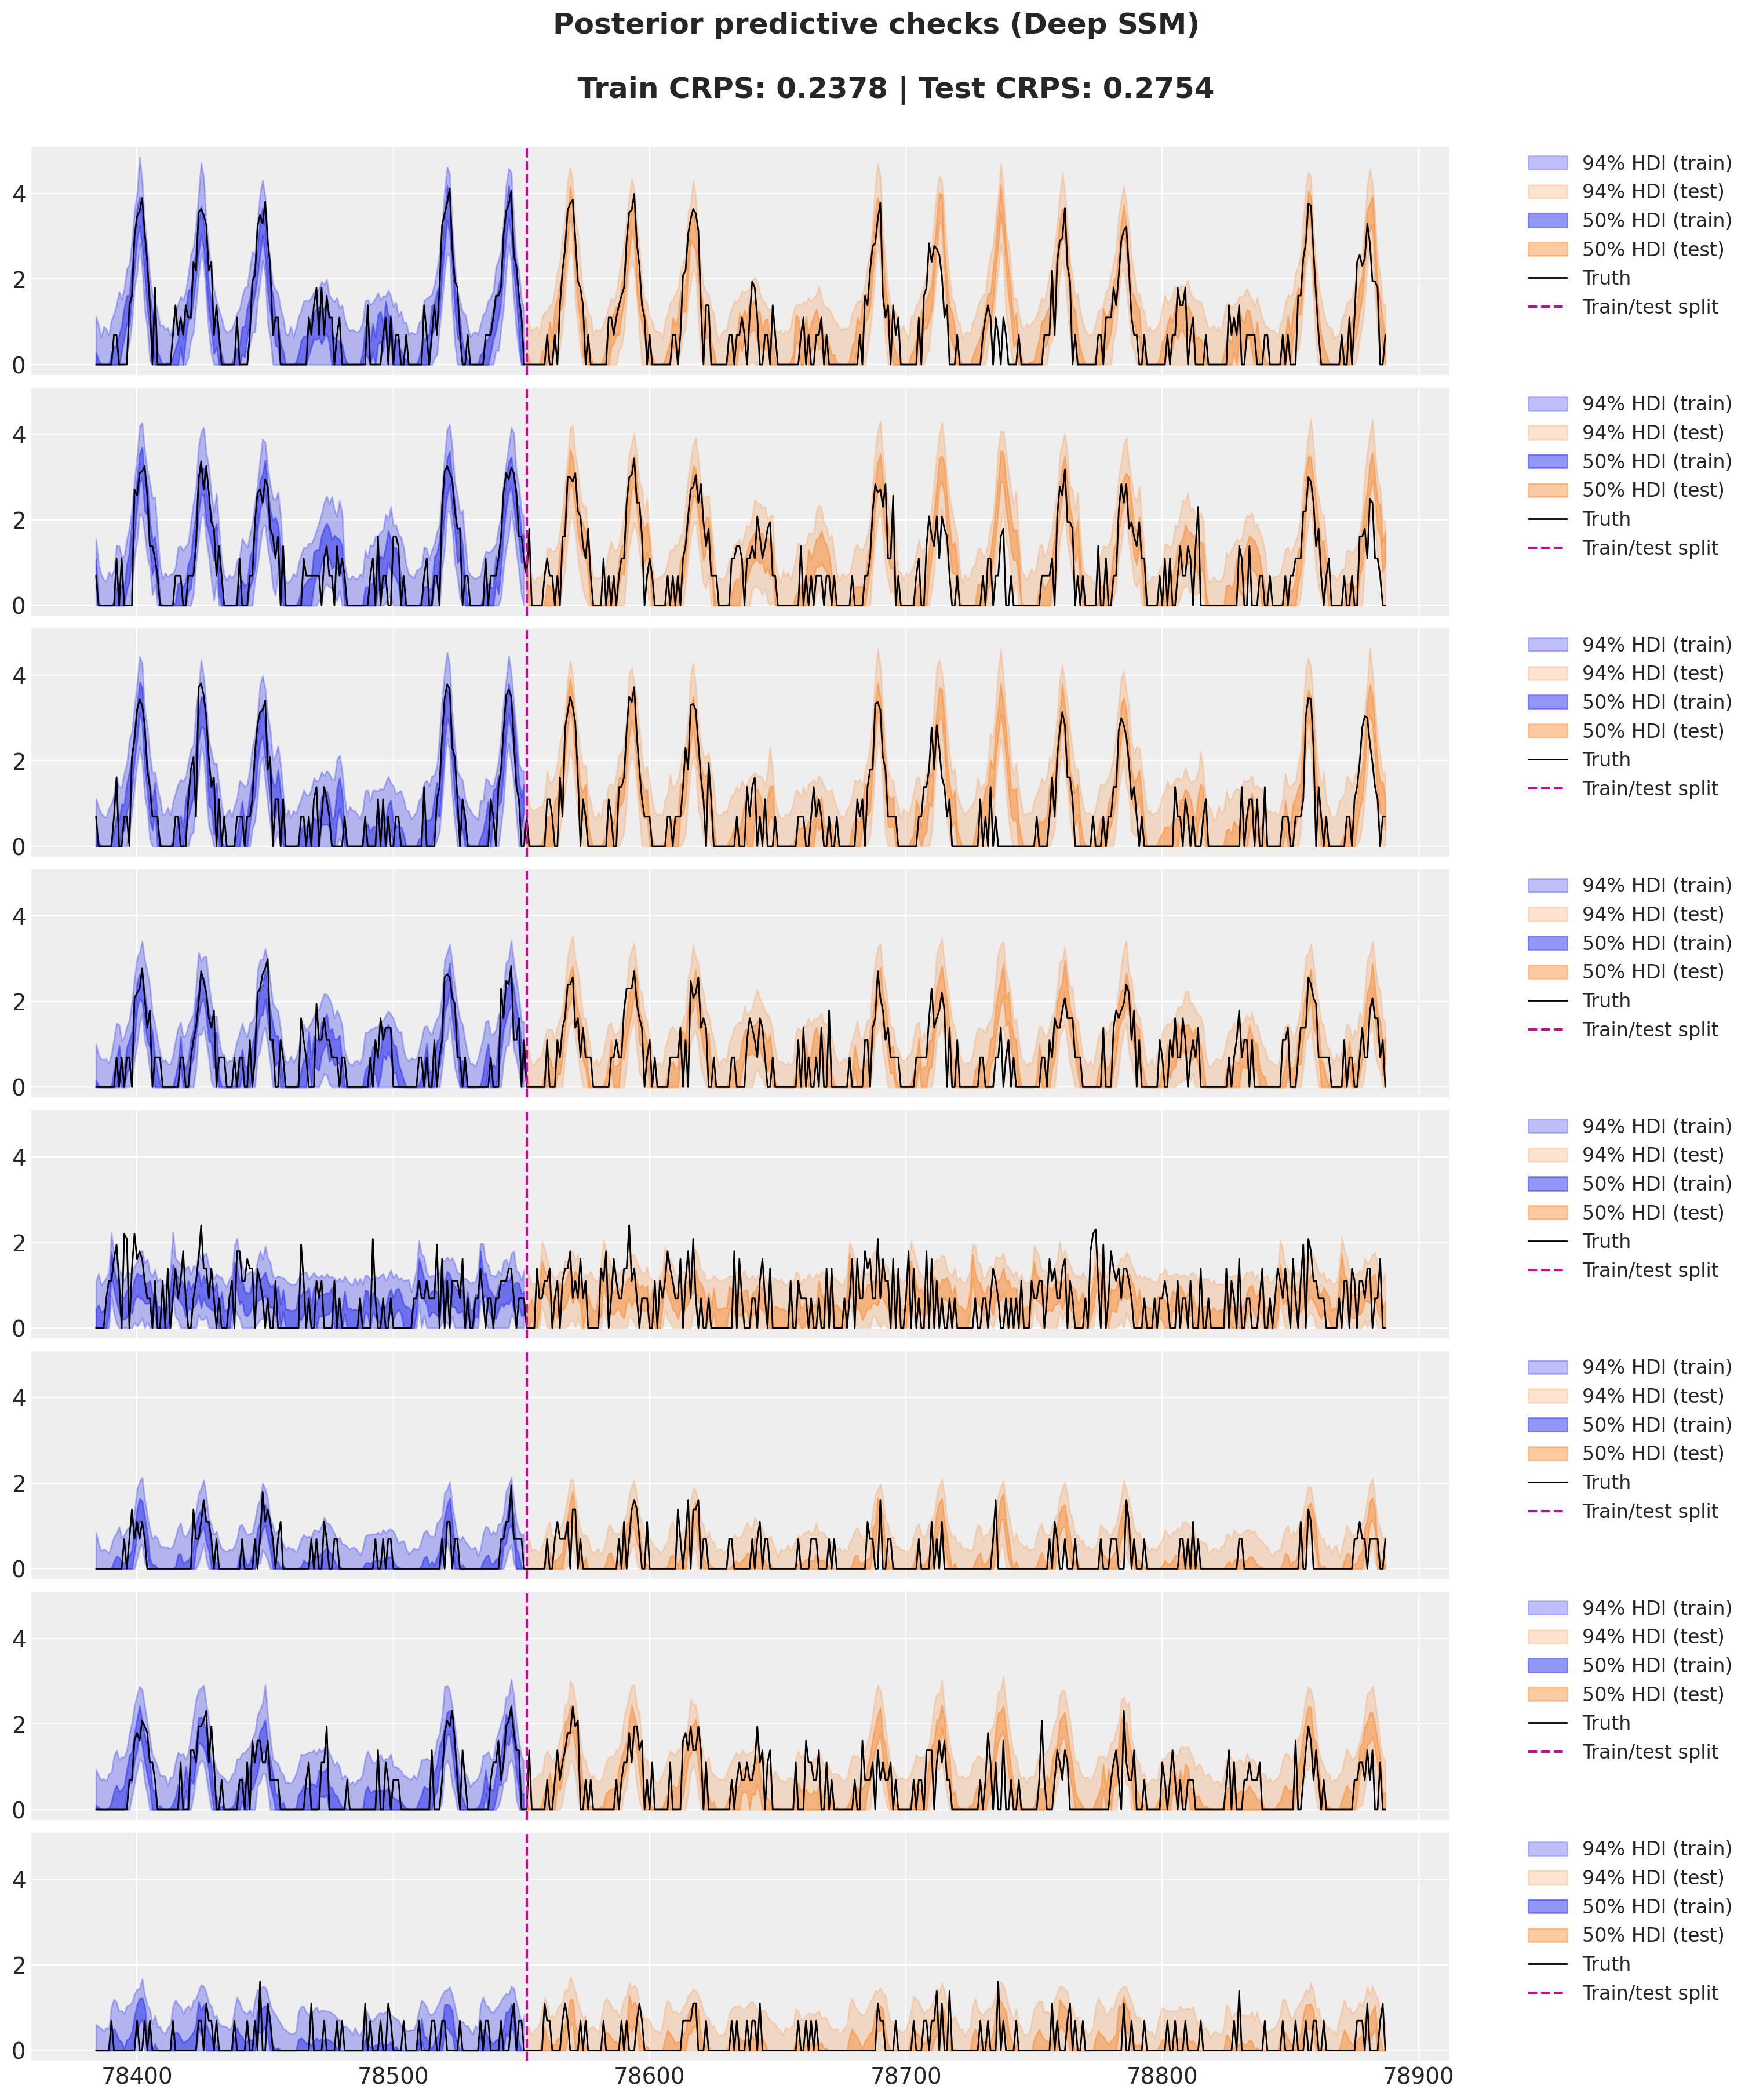

In [18]:
station = "ANTC"
idx = np.nonzero(dataset["stations"] == station)[0].item()

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(15, 18), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 24 * 7],
            idata_train["posterior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time_train) >= T1 - 24 * 7]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (train)",
            },
            smooth=False,
            ax=ax,
        )

        az.plot_hdi(
            time[time >= T1],
            idata_test["posterior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time) >= T1]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C1",
            fill_kwargs={
                "alpha": 0.2 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (test)",
            },
            smooth=False,
            ax=ax,
        )

    ax.plot(
        time[time >= T1 - 24 * 7],
        data[i, idx, T1 - 24 * 7 : T2],
        "black",
        lw=1,
        label="Truth",
    )

    ax.axvline(T1, color="C3", linestyle="--", label="Train/test split")

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
    )

fig.suptitle(
    f"""Posterior predictive checks (Deep SSM)

    Train CRPS: {crps_train:.4f} | Test CRPS: {crps_test:.4f}
    """,
    fontsize=18,
    fontweight="bold",
);

## Summary

In this notebook, we extended the hierarchical forecasting model from Part II by adding a neural network component to the state transition (Deep State-Space Model). Key numerical stability challenges were addressed to enable training over long time series (2160+ steps).


**Key takeaways:**

1. **Neural Network Integration**: We used Flax NNX modules with NumPyro's `nnx_module` to create a hybrid probabilistic-neural model.

2. **Pattern**: Neural networks must be initialized **outside** the model function and passed as arguments, following the pattern from [online_game_ate](https://juanitorduz.github.io/online_game_ate/).

3. **Station Embeddings are Critical**: Without them, the NN produces identical outputs for all stations. The embedding layer allows the NN to learn station-specific transition dynamics.

4. **Architecture Improvements**:
   - **Station embeddings**: NN knows which station it's processing
   - **LayerNorm**: Stability without constraining capacity
   - **Richer temporal features**: Separate hour-of-day and day-of-week encodings
   - **Input normalization**: `tanh(previous_level / 10)` keeps inputs bounded

5. **Numerical Stability**: Even with better architecture, long time series require careful handling - normalize inputs, bound outputs with tanh, and use safety clipping.

**Potential further improvements:**
- Replace MLP with GRU/LSTM for memory across time steps
- Attention mechanisms for long-range dependencies
- Residual connections combining NN with linear drift
